In [1]:
# Copyright 2024 Keysight Technologies Inc.

In [2]:
import numpy as np
import trueq as tq

# make a noisy simulator
sim = tq.Simulator().add_depolarizing(p=0.001)
sim.add_overrotation(single_sys=0.01, multi_sys=0.01)

# adding a rotation by 12 degrees to the first qubit in every 2-qubit gate,
# i.e. Z(12) is the noise we are going to try to characterize
mat = tq.Gate.from_generators("Z", 12).mat
sim.add_kraus([np.kron(mat, np.eye(2))])

In [3]:
cycle = tq.Cycle({(0, 1): tq.Gate.cz})

# generate SC circuits with 24 random cycles to get decays associated with XI
circuits = tq.make_sc(cycle, [24], pauli_decays=["XI"])
print(len(circuits))

30


In [4]:
# 20 equidistant points between -40 and 40 for trial values of phi
angles = np.linspace(-40, 40, 20)

all_circuits = tq.CircuitCollection()
for j, phi in enumerate(angles):
    # adds a Z(phi) rotation on qubit 0 gate before every CZ gate
    c = tq.compilation.CycleReplacement(
        cycle, replacement=[tq.Cycle({(0): tq.Gate.from_generators("Z", phi)}), cycle]
    )
    new_circs = tq.CircuitCollection(map(c.apply, circuits))

    # run circuit collection (with Z(phi)s inserted)
    sim.run(new_circs)

    # put all circuits into one callection, organized by the custom keyword "phi"
    all_circuits.append(new_circs.update_keys(phi=phi))

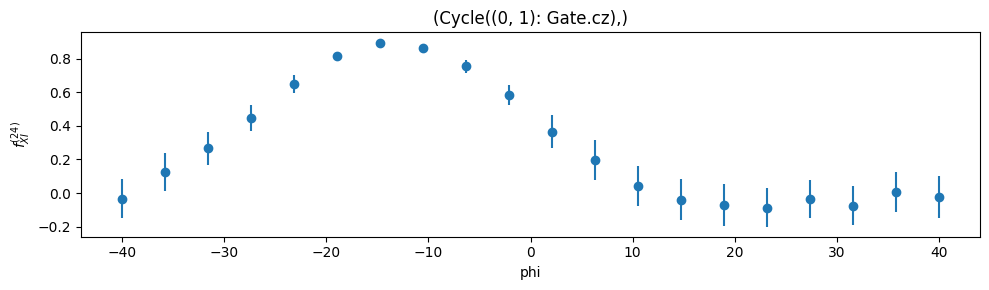

In [5]:
all_circuits.plot.compare("f_24_XI", "phi")